In [26]:
import numpy
from math import pi
%matplotlib inline
from matplotlib import pyplot, cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

from laplace_helper import plot_3D, L2_rel_error
from cg_helper import poisson_2d, p_analytical

In [27]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

x= numpy.linspace(0, l, nx)
y = numpy.linspace(0, h, ny)
X,Y = numpy.meshgrid(x,y)

#Source
u = 1
b_psi = numpy.zeros((ny, nx));
b_psi[0,:] = u
b_w = numpy.zeros((ny, nx))

#Initialization
psi_i = numpy.zeros((ny, nx))
w_i = numpy.zeros((ny, nx))

In [28]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [35]:
print(b)

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [29]:
def conjugate_gradient_stokes(w, psi, b_w, b_psi, dx, dy, l1_target):
    '''Performs Conjugate Gradient relaxation
        Assumes Dirichlet boundary conditions p=0
        
        Parameters:
            w, psi- intial guess
            b- source term
            dx- mesh spacing in x
            dy- mesh spacing in y
            l1_target- exit criteria
            
        Returns:
            w, psi- distribution after relaxation
    '''
    
    ny, nx = psi.shape
    r_psi = numpy.zeros((ny, nx))
    Ad_psi = numpy.zeros((ny, nx))
    r_w = numpy.zeros((ny, nx))
    Ad_w = numpy.zeros((ny, nx))
    
    l1_norm = 1
    iterations = 0
    l1_conv = []
    
    #compute intial residual, 
    #r0 = b-A*p0 = ?b*dx**2 + 4*p(i,j) -p(i,j+1) - p(i,j-1)...
    r_psi[1:-1, 1:-1] = b_psi[1:-1,1:-1]*dx**2 + 4*psi[1:-1,1:-1] - psi[1:-1,:-2] -\
            psi[1:-1,2:] - psi[:-2,1:-1] - psi[2:,1:-1]
    r_w[1:-1,1:-1] = b_w[1:-1,1:-1]*dx**2 + 4*w[1:-1,1:-1] - w[1:-1,:-2] -\
            w[1:-1,2:] - w[:-2,1:-1] - w[2:,1:-1]
        
    d_psi = r_psi.copy() #d0 = r0
    d_w = r_w.copy()
    
    top_psi = numpy.sum(r_psi*r_psi)
    Ad_psi[1:-1,1:-1] = -4*d_psi[1:-1,1:-1]+d_psi[1:-1,2:]+d_psi[1:-1,:-2] + \
        d_psi[2:,1:-1] + d_psi[:-2,1:-1]
    bot_psi = numpy.sum(d_psi*Ad_psi)
    
    top_w = numpy.sum(r_w*r_w)
    Ad_w[1:-1,1:-1] = -4*d_w[1:-1,1:-1]+d_w[1:-1,2:]+d_w[1:-1,:-2] + \
        d_w[2:,1:-1] + d_w[:-2,1:-1]
    bot_w = numpy.sum(d_w*Ad_w)
        
    #Iterations
    while l1_norm > l1_target:
        wk = w.copy()
        psik = psi.copy()
        rk_psi = r_psi.copy()
        dk_psi = d_psi.copy()
        rk_w = r_w.copy()
        dk_w = d_w.copy()
        
        #alpha = rk*rk/(A*dk*dk)
        alpha_psi = top_psi/bot_psi
        alpha_w = top_w/bot_w
        
        #update p(k+1)
        psi = psik + alpha_psi*dk_psi
        w = wk + alpha_w*dk_w
        
        #r(k+1) = r(k)-alpha*A*dk
        r_psi = rk_psi - alpha_psi*Ad_psi
        r_w = rk_w - alpha_w*Ad_w
        
        #beta = r(k+1)*r(k+1)/(r(k)*r(k))
        top_psi1 = numpy.sum(r_psi*r_psi)
        beta_psi = top_psi1/top_psi
        top_psi = top_psi1
        
        top_w1 = numpy.sum(r_w*r_w)
        beta_w = top_w1/top_w
        top_w = top_w1
        
        #d(k+1) = r(k+1) +beta*d(k)
        d_psi = r_psi + beta_psi*dk_psi
        Ad_psi[1:-1,1:-1] = -4*d_psi[1:-1,1:-1]+d_psi[1:-1,2:]+d_psi[1:-1,:-2] + \
            d_psi[2:,1:-1] + d_psi[:-2,1:-1]
        
        d_w = r_w + beta_w*dk_w
        Ad_w[1:-1,1:-1] = -4*d_w[1:-1,1:-1]+d_w[1:-1,2:]+d_w[1:-1,:-2] + \
            d_w[2:,1:-1] + d_w[:-2,1:-1]
        
        top_psi = numpy.sum(d_psi*Ad_psi)
        top_w = numpy.sum(d_w*Ad_w)
        
        #Enforce BCs
        
        psi[:, 0] = 0
        psi[:,-1] = 0
        psi[0, :] = 0
        psi[-1,:] = 0
        w[:, 0] = 0
        w[2:,-1] = -1/(2*dy**2)*(8*psi[2:,-2] - psi[2:,-3]) -3*u/dy
        w[0, :] = 0
        w[-1,:] = 0
        
        
        l1_norm = min(L1norm(psik,psi), L1norm(wk, w))
        iterations += 1
        l1_conv.append(l1_norm)
        
    print('Number of CG iterations: {0:d}'.format(iterations))
    return w, psi, l1_conv

In [30]:
w, psi, l1_conv = conjugate_gradient_stokes(w_i, psi_i, b_w, b_psi, dx, dy, l1_target)

Number of CG iterations: 1


/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars
/home/gil/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in double_scalars


In [34]:
print(psi)

[[  0.   0.   0. ...,   0.   0.   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 ..., 
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.  nan  nan ...,  nan  nan   0.]
 [  0.   0.   0. ...,   0.   0.   0.]]


/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


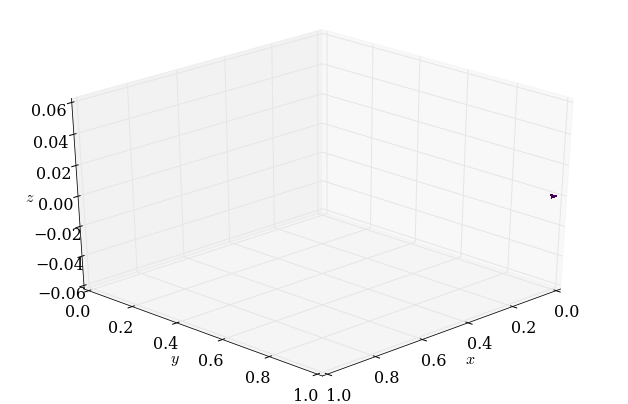

In [32]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
ax = fig.gca(projection='3d')
#ax = fig.gca()
X,Y = numpy.meshgrid(x,y)
surf = ax.plot_surface(X,Y,w[:], rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)



#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.view_init(30,45)